In [59]:
import pandas as pd
import numpy as np
import geopandas as gpd
import glob
from sklearn.metrics.pairwise import haversine_distances
from math import radians
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import RadiusNeighborsRegressor
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
nodes = pd.read_csv('nodes.csv')
nodes.head()

,lng,lat,id
0,-74.017931,40.706175,0
1,-74.017869,40.706349,1
2,-74.017789,40.706519,2
3,-74.017690,40.706683,3
4,-74.017574,40.706840,4


In [72]:
nodes.shape

(236258, 3)

In [3]:
# TLC data, aggragated per day
daily_all = pd.read_csv('TLC_daily.csv')
daily_all.head()

,day,id,pickups
0,1.0,0,19.0
1,1.0,1,18.0
2,1.0,2,18.0
3,1.0,3,17.0
4,1.0,4,13.0


In [63]:
daily_all.describe()

,day,id,pickups
count,3.591122e+07,3.591122e+07,3.591122e+07
mean,7.650000e+01,2.151819e+05,6.241633e+00
std,4.387767e+01,1.469457e+05,4.917505e+01
min,1.000000e+00,0.000000e+00,0.000000e+00
25%,3.875000e+01,1.022800e+05,0.000000e+00
50%,7.650000e+01,2.178005e+05,0.000000e+00
75%,1.142500e+02,3.209220e+05,0.000000e+00
max,1.520000e+02,2.414378e+06,3.923000e+03


In [4]:
# train-val-test split of intersection nodes

np.random.seed(2002)

nodes_train, nodes_test = train_test_split(nodes.id.unique(), test_size=0.3)

nodes_train, nodes_val = train_test_split(nodes_train, test_size=0.3)
print(len(nodes_train), len(nodes_val), len(nodes_test))

115766 49614 70878


In [5]:
# merging with nodes data to get locations

daily_all_mer = daily_all.merge(nodes, on='id')

daily_all_train = daily_all_mer[daily_all_mer.id.isin(nodes_train)]
daily_all_val = daily_all_mer[daily_all_mer.id.isin(nodes_val)]
daily_all_test = daily_all_mer[daily_all_mer.id.isin(nodes_test)]

In [6]:
# weighting function

def weightFunc(dist, lamb=0):

    return np.exp(-lamb*np.array(dist))


def test_predictions(model, bestParams, data_train, data_test, weights=False):
    
    model.fit(data_train[0], data_train[1])
    
    if weights == True:
        
        dist, ind = model.kneighbors(data_test[0])
        weights = weightFunc(dist, bestParams['lambda'])
        pred_test = np.sum(weights*data_train[1][ind].reshape(weights.shape), axis=1)/np.sum(weights, axis=1)
    else:
        pred_test = model.predict(X_test)
    
    return r2_score(data_test[1], pred_test)

In [89]:
# simple KNN

n_days = 30
bestParams = {'lambda':None, 'best_K':None}
days_r2 = []

for day in daily_all.day.unique()[:n_days]:
 
    X_train, y_train = daily_all_train[daily_all_train.day == day][['lat', 'lng']].values, daily_all_train[daily_all_train.day == day]['pickups'].values
    X_val, y_val = daily_all_val[daily_all_val.day == day][['lat', 'lng']].values, daily_all_val[daily_all_val.day == day]['pickups'].values
    X_test, y_test = daily_all_test[daily_all_test.day == day][['lat', 'lng']].values, daily_all_test[daily_all_test.day == day]['pickups'].values
    
    best_mse = 100000
    best_K = None
    
    for k in range(1, 10):

        mod = KNeighborsRegressor(n_neighbors=k, metric='haversine')
        mod.fit(X_train, y_train)
        mse = mean_squared_error(y_val, mod.predict(X_val))
        if mse < best_mse:
            best_mse = mse
            best_K = k
    bestParams['best_K'] = best_K
    
    test_r2 = test_predictions(KNeighborsRegressor(n_neighbors=best_K, metric='haversine'), 
                                                   bestParams=bestParams, data_train=(X_train, y_train), 
                                                    data_test=(X_test, y_test))
    days_r2.append(test_r2)
    
    print('day:', day, 'test r2:', test_r2)
    
    

day: 1.0 test r2: 0.8754203387971544
day: 2.0 test r2: 0.8743714421394224
day: 3.0 test r2: 0.8773265970832933
day: 4.0 test r2: 0.9033324370276812
day: 5.0 test r2: 0.8933431527757413
day: 6.0 test r2: 0.8931041462634359
day: 7.0 test r2: 0.8853647782721987
day: 8.0 test r2: 0.8837338444005328
day: 9.0 test r2: 0.8651581914496127
day: 10.0 test r2: 0.8651867981283757
day: 11.0 test r2: 0.8917118068986851
day: 12.0 test r2: 0.8731062602003753
day: 13.0 test r2: 0.8843706859759672
day: 14.0 test r2: 0.8919310314847362
day: 15.0 test r2: 0.8768273016949748
day: 16.0 test r2: 0.8763054911073465
day: 17.0 test r2: 0.8829543891505629
day: 18.0 test r2: 0.8693833119512945
day: 19.0 test r2: 0.8926829697453995
day: 20.0 test r2: 0.8846751627410703
day: 21.0 test r2: 0.8900096886634816
day: 22.0 test r2: 0.8804976450903192
day: 23.0 test r2: 0.8395140277090558
day: 24.0 test r2: 0.895487644371896
day: 25.0 test r2: 0.9089915062961187
day: 26.0 test r2: 0.8989957279822324
day: 27.0 test r2: 0.8

In [90]:
# weighted KNN - fixed K

n_days = 30
bestParams = {'lambda':None, 'best_K':None}
best_r2_weighted = []
K = 200

for day in daily_all.day.unique()[:n_days]:
 
    X_train, y_train = daily_all_train[daily_all_train.day == day][['lat', 'lng']].values, daily_all_train[daily_all_train.day == day]['pickups'].values
    X_val, y_val = daily_all_val[daily_all_val.day == day][['lat', 'lng']].values, daily_all_val[daily_all_val.day == day]['pickups'].values
    X_test, y_test = daily_all_test[daily_all_test.day == day][['lat', 'lng']].values, daily_all_test[daily_all_test.day == day]['pickups'].values
    
    best_mse = 1000000
    best_lambda = None
    best_r2 = None
    
    mod = KNeighborsRegressor(n_neighbors=K, metric='haversine')
    mod.fit(X_train, y_train)
    dist, ind = mod.kneighbors(X_val)
    
    for lam in np.logspace(-4.5, 4.5):

        weights = weightFunc(dist, lam)
        pred_val = np.sum(weights*y_train[ind].reshape(weights.shape), axis=1)/np.sum(weights, axis=1)

        mse = mean_squared_error(y_val, pred_val)
        r2 = r2_score(y_val, pred_val)
        if mse < best_mse:
            best_mse = mse
            best_lambda = lam
            best_r2 = r2
            
    bestParams['lambda'] = best_lambda
    
    test_r2 = test_predictions(KNeighborsRegressor(n_neighbors=K, metric='haversine'), 
                                                   bestParams=bestParams, data_train=(X_train, y_train), 
                                                    data_test=(X_test, y_test), weights=True)
    best_r2_weighted.append(test_r2)
            
    print('day:', day, 'test r2:', test_r2)
    
    

day: 1.0 test r2: 0.8911134633047125
day: 2.0 test r2: 0.8767329443627845
day: 3.0 test r2: 0.8924631700021618
day: 4.0 test r2: 0.9077586323181323
day: 5.0 test r2: 0.8974555904268973
day: 6.0 test r2: 0.8909739439253568
day: 7.0 test r2: 0.8887405028156314
day: 8.0 test r2: 0.8869846340072505
day: 9.0 test r2: 0.8743048100225843
day: 10.0 test r2: 0.8778623410298863
day: 11.0 test r2: 0.8937575739423004
day: 12.0 test r2: 0.8884102051556624
day: 13.0 test r2: 0.8834069580492215
day: 14.0 test r2: 0.8915881886255462
day: 15.0 test r2: 0.8791618222667008
day: 16.0 test r2: 0.8845553063011926
day: 17.0 test r2: 0.8940257296005851
day: 18.0 test r2: 0.8766583126978693
day: 19.0 test r2: 0.8943715716218794
day: 20.0 test r2: 0.8866343195299305
day: 21.0 test r2: 0.892276134880992
day: 22.0 test r2: 0.8857632555108766
day: 23.0 test r2: 0.859661056389827
day: 24.0 test r2: 0.9041226311438074
day: 25.0 test r2: 0.9193106796158401
day: 26.0 test r2: 0.9059674481172729
day: 27.0 test r2: 0.89

In [70]:
best_r2_weighted_radius = []

r = 0.003  # radius around which to get neighbors from
n_days = 30

for day in daily_all.day.unique()[:30]:
    
#     df_day = daily_all[daily_all.day == day]
#     df_day = df_day.merge(nodes, on='id')
    
#     X_train, y_train = df_day[df_day.id.isin(nodes_train)][['lat', 'lng']], df_day[df_day.id.isin(nodes_train)][['pickups']]
#     X_val, y_val = df_day[df_day.id.isin(nodes_val)][['lat', 'lng']], df_day[df_day.id.isin(nodes_val)][['pickups']]
#     X_test, y_test = df_day[df_day.id.isin(nodes_test)][['lat', 'lng']], df_day[df_day.id.isin(nodes_test)][['pickups']]
 
    X_train, y_train = daily_all_train[daily_all_train.day == day][['lat', 'lng']].values, daily_all_train[daily_all_train.day == day]['pickups'].values
    X_val, y_val = daily_all_val[daily_all_val.day == day][['lat', 'lng']].values, daily_all_val[daily_all_val.day == day]['pickups'].values
    X_test, y_test = daily_all_test[daily_all_test.day == day][['lat', 'lng']].values, daily_all_test[daily_all_test.day == day]['pickups'].values
    
    best_mse = 1000000
    best_lambda = None
    best_r2 = None
    
#     mod = KNeighborsRegressor(n_neighbors=20, metric='haversine')
#     mod.fit(X_train, y_train)
#     dist, ind = mod.kneighbors(X_val)

    mod = NearestNeighbors(radius=r, metric='haversine')
    mod.fit(X_train, y_train)
    dist, ind = mod.radius_neighbors(X_val, radius=r, sort_results=True)
    dist = np.array([list(i) for i in dist])
    pad = len(max(dist, key=len))
    dist = np.array([i + [np.inf]*(pad-len(i)) for i in dist])
    ind = np.array([list(i) for i in ind])
    ind = np.array([i + [0]*(pad-len(i)) for i in ind])
    
    for lam in np.logspace(-4.5, 4.5):

        weights = weightFunc(dist, lam)
        pred_val = np.sum(weights*y_train[ind].reshape(weights.shape), axis=1)/np.sum(weights, axis=1)
        pred_val = np.nan_to_num(pred_val, nan=0)

        mse = mean_squared_error(y_val, pred_val)
        r2 = r2_score(y_val, pred_val)
#         print(lam, r2)
        if mse < best_mse:
            best_mse = mse
            best_lambda = lam
            best_r2 = r2
#     print(best_lambda)
    
#     test_mod = KNeighborsRegressor(n_neighbors=20, metric='haversine')
#     test_mod.fit(X_train, y_train)
    dist, ind = mod.radius_neighbors(X_test, radius=r, sort_results=True)
    dist = np.array([list(i) for i in dist])
    dist = np.array([i + [np.inf]*(pad-len(i)) for i in dist])
    ind = np.array([list(i) for i in ind])
    ind = np.array([i + [0]*(pad-len(i)) for i in ind])
    
    weights = weightFunc(dist, best_lambda)
    pred_test = np.sum(weights*y_train[ind].reshape(weights.shape), axis=1)/np.sum(weights, axis=1)
    pred_test = np.nan_to_num(pred_test, nan=0)
    
    print('day:', day, ': ', 'best validation r2:', best_r2, 'best test r2:', r2_score(y_test, pred_test))
    best_r2_weighted_radius.append(r2_score(y_test, pred_test))

day: 1.0 :  best validation r2: 0.9038779765715924 best test r2: 0.8911297498352448
day: 2.0 :  best validation r2: 0.8902659639232632 best test r2: 0.8767509056638976
day: 3.0 :  best validation r2: 0.9015939113888237 best test r2: 0.8924879642037344
day: 4.0 :  best validation r2: 0.9087473035550023 best test r2: 0.9077854667635248
day: 5.0 :  best validation r2: 0.8869607015274086 best test r2: 0.8974718081043321
day: 6.0 :  best validation r2: 0.8928536269806264 best test r2: 0.8910497900871421
day: 7.0 :  best validation r2: 0.8859735879358215 best test r2: 0.8887504603752231
day: 8.0 :  best validation r2: 0.8902175947738535 best test r2: 0.8869942218343043
day: 9.0 :  best validation r2: 0.8814264781875754 best test r2: 0.8743114517513294
day: 10.0 :  best validation r2: 0.8981620277473309 best test r2: 0.8778720926719761
day: 11.0 :  best validation r2: 0.8895014397992345 best test r2: 0.8937745130828626
day: 12.0 :  best validation r2: 0.8872719502730526 best test r2: 0.888418

In [65]:
gs = GridSearchCV(est, param_grid={'n_neighbors':range(1, 10)})
gs.fit(X_train, y_train)

GridSearchCV(estimator=KNeighborsRegressor(metric='haversine'),
             param_grid={'n_neighbors': range(1, 10)})

In [66]:
gs.best_params_

{'n_neighbors': 2}

In [88]:
len(best_r2_weighted)

0

In [91]:
pd.DataFrame({'day':daily_all.day.unique()[:30], 
              'test_r2_KNN':days_r2, 'test_r2_weightedN_k=20':best_r2_weighted, 
             'test_r2_weightedN_radius500m':best_r2_weighted_radius})

,day,test_r2_KNN,test_r2_weightedN_k=20,test_r2_weightedN_radius500m
0,1.0,0.875420,0.891113,0.891130
1,2.0,0.874371,0.876733,0.876751
2,3.0,0.877327,0.892463,0.892488
3,4.0,0.903332,0.907759,0.907785
4,5.0,0.893343,0.897456,0.897472
5,6.0,0.893104,0.890974,0.891050
6,7.0,0.885365,0.888741,0.888750
7,8.0,0.883734,0.886985,0.886994
8,9.0,0.865158,0.874305,0.874311
9,10.0,0.865187,0.877862,0.877872


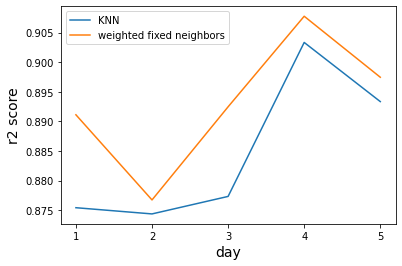

In [39]:
plt.plot(daily_all.day.unique()[:5], days_r2, label='KNN')
plt.plot(daily_all.day.unique()[:5], best_r2_weighted, label='weighted fixed neighbors')
# plt.plot(daily_all.day.unique()[:5], best_r2_weighted_radius)
plt.xlabel('day', fontsize=14)
plt.ylabel('r2 score', fontsize=14)
plt.xticks(range(1,6))
plt.legend()